In [15]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from requests import get
from bs4 import BeautifulSoup
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [16]:
DATA_PATH = "data/"
AFDB_2019 = "Data.csv"
db_zero = pd.read_csv(DATA_PATH + AFDB_2019, sep=',')

INDICATORS = "Indicator.csv"
inds = pd.read_csv(DATA_PATH + INDICATORS, sep=',')

print(db_zero.shape)
db_zero.dropna(subset=['Date', 'Value','Country','Indicator'],inplace = True) #instead of any by default, which concludes our rows are good
print(db_zero.shape)


db_zero.Date = db_zero.Date.apply(lambda x : x.split("-")[0]).astype(int)
db_zero.rename(columns = {'Date':'Year'}, inplace = True)
db_zero.Scale = db_zero.Scale.astype(int)
db_zero.Value = db_zero.Value.astype(float)
db_zero.head()

(2792569, 9)
(2792569, 9)


,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
0,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2000,9.133374
1,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2001,8.535367
2,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2002,7.238168
3,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2003,7.217622
4,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2004,7.373657


In [8]:
db = pd.pivot_table(db_zero, values='Value', index=['Country', 'Year'], columns=['Indicator'])
print(db.shape)
db.head()

(9850, 1279)


Indicator     AFDB_CPIA_EM_DB_S  AFDB_CPIA_EM_FP_S  AFDB_CPIA_EM_MM_S  \
Country Year                                                            
ADB     1960                NaN                NaN                NaN   
        1961                NaN                NaN                NaN   
        1962                NaN                NaN                NaN   
        1963                NaN                NaN                NaN   
        1964                NaN                NaN                NaN   

Indicator     AFDB_CPIA_EM_S  AFDB_CPIA_IRI_ID_S  AFDB_CPIA_IRI_RI_S  \
Country Year                                                           
ADB     1960             NaN                 NaN                 NaN   
        1961             NaN                 NaN                 NaN   
        1962             NaN                 NaN                 NaN   
        1963             NaN                 NaN                 NaN   
        1964             NaN                 NaN                 NaN   

Indicator     AFDB_CPIA_N  AFDB_CPIA_PSIE_BHR_S  AFDB_CPIA_PSIE_EPRU_S  \
Country Year                                                             
ADB     1960          NaN                   NaN                    NaN   
        1961          NaN                   NaN                    NaN   
        1962          NaN                   NaN                    NaN   
        1963          NaN                   NaN                    NaN   
        1964          NaN                   NaN                    NaN   

Indicator     AFDB_CPIA_PSIE_EPR_S  ...  TG.WEO.TXGXO_R.KD  TG.WEO.TXG_D.WD  \
Country Year                        ...                                       
ADB     1960                   NaN  ...                NaN              NaN   
        1961                   NaN  ...                NaN              NaN   
        1962                   NaN  ...                NaN              NaN   
        1963                   NaN  ...                NaN              NaN   
        1964                   NaN  ...                NaN              NaN   

Indicator     TG.WEO.TXG_R.KD  TG.WEO.TXG_R.ZG  TG.WEO.TXS.CD  TG.WEO.TX_D.WD  \
Country Year                                                                    
ADB     1960              NaN              NaN            NaN             NaN   
        1961              NaN              NaN            NaN             NaN   
        1962              NaN              NaN            NaN             NaN   
        1963              NaN              NaN            NaN             NaN   
        1964              NaN              NaN            NaN             NaN   

Indicator     TG.WEO.TX_R.KD  TG.WEO.TX_R.ZG  VC.PRS.UNSEC  indicateur3  
Country Year                                                             
ADB     1960             NaN             NaN           NaN          NaN  
        1961             NaN             NaN           NaN          NaN  
        1962             NaN             NaN           NaN          NaN  
        1963             NaN             NaN           NaN          NaN  
        1964             NaN             NaN           NaN          NaN  

[5 rows x 1279 columns]

In [9]:
#db.loc['CIV',1960]

In [10]:
db_verif = db.dropna(how='all')
db_verif.shape
#Still, no key(country,year) has all nans, each key has its indicators !

(9850, 1279)

In [11]:
'''
#Trouver les indicateurs qui ont plus que 9840 nans sur 9850 !
for i in range(db.shape[1])  :  
    val = db.isnull().sum()[i]
    if (val > 9840):
        print(db.columns[i])
'''        

'\n#Trouver les indicateurs qui ont plus que 9840 nans sur 9850 !\nfor i in range(db.shape[1])  :  \n    val = db.isnull().sum()[i]\n    if (val > 9840):\n        print(db.columns[i])\n'

In [12]:
'''
f = plt.figure(figsize=(19, 15))
plt.matshow(db.corr(), fignum=f.number)
plt.xticks(range(db.shape[1]), db.columns, fontsize=14, rotation=45)
plt.yticks(range(db.shape[1]), db.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)
'''

"\nf = plt.figure(figsize=(19, 15))\nplt.matshow(db.corr(), fignum=f.number)\nplt.xticks(range(db.shape[1]), db.columns, fontsize=14, rotation=45)\nplt.yticks(range(db.shape[1]), db.columns, fontsize=14)\ncb = plt.colorbar()\ncb.ax.tick_params(labelsize=14)\nplt.title('Correlation Matrix', fontsize=16);\n"

In [13]:
#corr = db.corr()
#corr.style.background_gradient(cmap='coolwarm').set_precision(3)

In [14]:
inds_social = inds[inds['Parent']=='KN.B14']
print(inds.shape)
print(inds_social.shape)

(1677, 11)
(1, 11)


In [20]:
def lowercase_all(text):
    return text.lower()

In [31]:
education_keywords = ['education','literacy','enroll','school','teach','pupil','student','repeater']
inds_education = inds[inds.Name.apply(lowercase_all).str.contains('|'.join(education_keywords))]

In [33]:
inds_education.shape
inds_education

,Order,Name,Parent,Code,Indicator_Id,Source_Note,Derivation_Rule,IsDerived,Weights_Indicator,Aggregation_Rule,Unit
638,639,Governance-Health and primary education (Score),KN.B13,PS.WGI.GOV.COMP.HEALT,854.0,Worldwide Governance Indicators (WGI): Politic...,NaN,0.0,NaN,NaN,Score
639,640,Governance-Higher education and training (Score),KN.B13,PS.WGI.GOV.COMP.HEDU,855.0,Worldwide Governance Indicators (WGI): Politic...,NaN,0.0,NaN,NaN,Score
669,670,Global Competitiveness Index: Health and prima...,KN.B13,PS.WGI.GOV.COMP.HEALTH.RANK,1228.0,The Global Competitiveness,NaN,0.0,NaN,NaN,NaN
670,671,Global Competitiveness Index: Health and prima...,KN.B13,PS.WGI.GOV.COMP.HEALTH.Score,1244.0,NaN,NaN,0.0,NaN,NaN,NaN
671,672,Global Competitiveness Index: Higher education...,KN.B13,PS.WGI.GOV.COMP.HEDUC.RANK,1230.0,The Global Competitiveness,NaN,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1636,1637,Teaching staff at second level - Total (number),KN.B14,CTRY.SE.TCHR.SECOND,1878.0,Source: National Statistics Offices,NaN,0.0,NaN,NaN,number
1637,1638,Teaching staff at third level - Total (number),KN.B14,CTRY.SE.TCHR.THIRD,1879.0,Source: National Statistics Offices,NaN,0.0,NaN,NaN,number
1638,1639,Third level student enrollment - Female (number),KN.B14,CTRY.SE.TER.ENRR.FE.TOT,1792.0,Source: National Statistics Offices,NaN,0.0,NaN,NaN,number
1639,1640,Third level student enrollment - Total (number),KN.B14,CTRY.SE.TER.ENRR.TOT,1793.0,Source: National Statistics Offices,NaN,0.0,NaN,NaN,number


In [43]:
education_codes = inds_education.Code.tolist()

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
0,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2000,9.133374
1,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2001,8.535367
2,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2002,7.238168
3,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2003,7.217622
4,AFRICA,AFR,"Inflation, consumer prices (annual %)",FP.CPI.TOTL.ZG,annual %,1,A,2004,7.373657
...,...,...,...,...,...,...,...,...,...
2792564,ZZ-Multinational,ZZM,Trade of Goods (As % of World Trade of Goods),DT.COM.TRAD.ZS,as % of World Trade of Goods,1,A,2004,2.450148
2792565,ZZ-Multinational,ZZM,Trade of Goods (As % of World Trade of Goods),DT.COM.TRAD.ZS,as % of World Trade of Goods,1,A,2005,2.669810
2792566,ZZ-Multinational,ZZM,Trade of Goods (As % of World Trade of Goods),DT.COM.TRAD.ZS,as % of World Trade of Goods,1,A,2006,2.848929
2792567,ZZ-Multinational,ZZM,Trade of Goods (As % of World Trade of Goods),DT.COM.TRAD.ZS,as % of World Trade of Goods,1,A,2007,2.910938


In [50]:
db_education = db_zero[db_zero.Indicator.str.match('|'.join(education_codes))]
db_education

,CountryName,Country,IndicatorName,Indicator,Units,Scale,Frequency,Year,Value
10970,AFRICA,AFR,Governance-Health and primary education (Score),PS.WGI.GOV.COMP.HEALT,score,1,A,2008,4.119355
10971,AFRICA,AFR,Governance-Health and primary education (Score),PS.WGI.GOV.COMP.HEALT,score,1,A,2009,3.989355
10972,AFRICA,AFR,Governance-Higher education and training (Score),PS.WGI.GOV.COMP.HEDU,score,1,A,2008,3.138710
10973,AFRICA,AFR,Governance-Higher education and training (Score),PS.WGI.GOV.COMP.HEDU,score,1,A,2009,3.127419
11110,AFRICA,AFR,Ibrahim Index: EDUCATION Sub-categories,PS.IB.IN.AF.GOV.SC.EDC,NaN,1,A,2000,40.775472
...,...,...,...,...,...,...,...,...,...
2790745,ADF eligible countries (all),ADF,"School enrollment, primary, male (% net)",SE.PRM.NENR.MA,% net,1,A,1999,53.233463
2791019,Oper. Dept. ORSB,SOUTHB,"School enrollment, primary, female (% net)",SE.PRM.NENR.FE,% net,1,A,1999,64.678771
2791020,Oper. Dept. ORSB,SOUTHB,"School enrollment, primary, male (% net)",SE.PRM.NENR.MA,% net,1,A,1999,69.424815
2791125,Fragile States,FRAGILE,"School enrollment, primary, total (% net)",SE.PRM.NENR,% net,1,A,1999,52.482663


In [51]:
db = pd.pivot_table(db_education, values='Value', index=['Country', 'Year'], columns=['Indicator'])

Text(0.5, 1.05, 'Correlation Matrix')

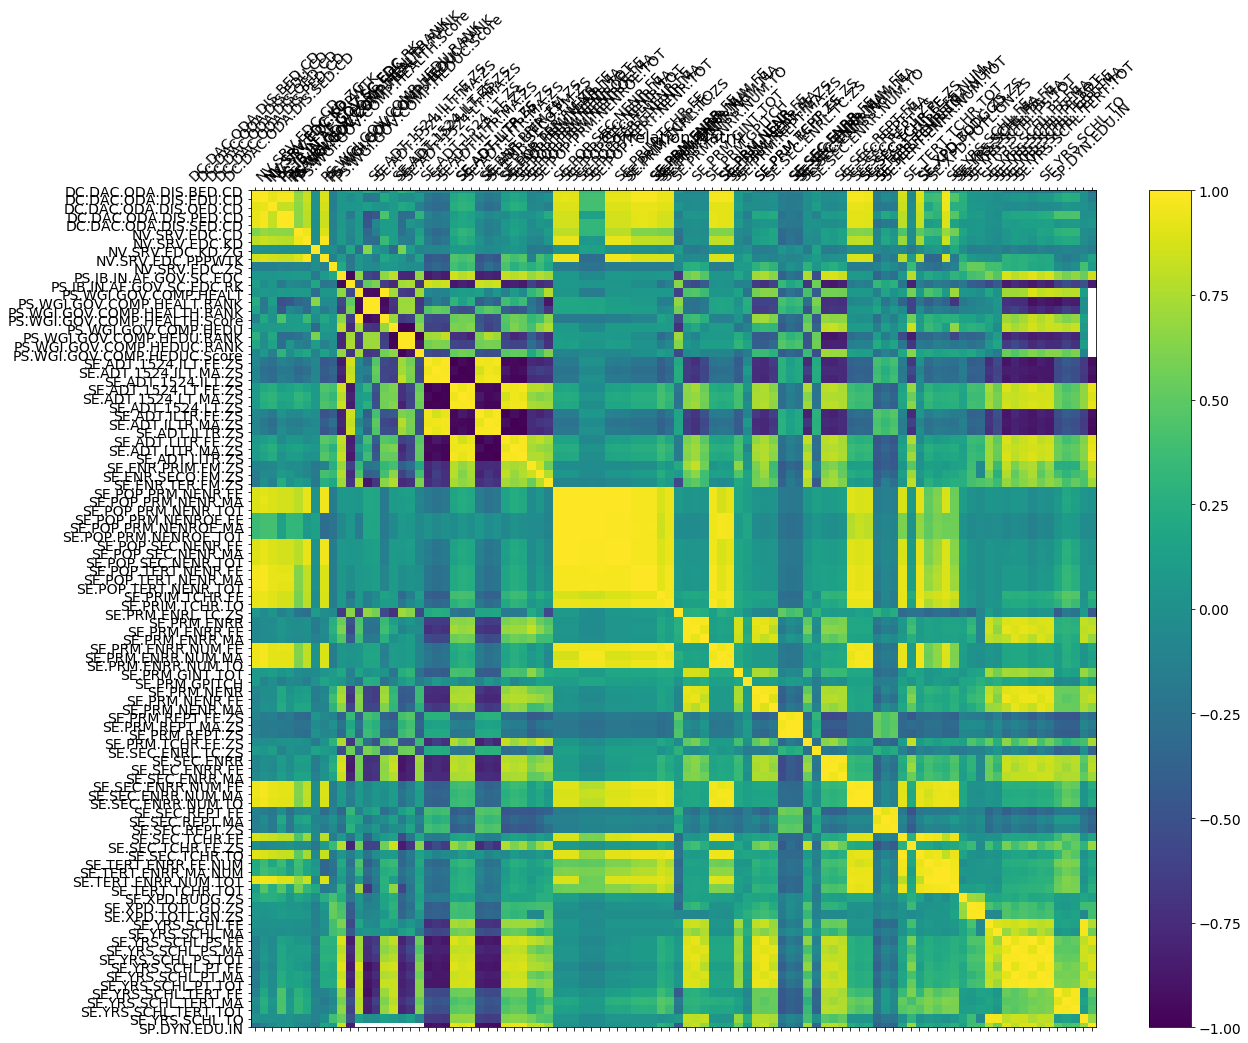

In [52]:
f = plt.figure(figsize=(19, 15))
plt.matshow(db.corr(), fignum=f.number)
plt.xticks(range(db.shape[1]), db.columns, fontsize=14, rotation=45)
plt.yticks(range(db.shape[1]), db.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

In [55]:
corr = db.corr()
corr.style.background_gradient(cmap='plasma').set_precision(3)